## 분류 Classification
+ Naive Bayes
+ Logistic Regression
+ Decision Tree
+ Support Vector Machine
+ Nearest Neighbor
+ Neural Network
+ Ensemble

## 앙상블 방법
+ Bagging
+ Boosting

앙상블의 기본 알고리즘으로 보통 결정 트리를 사용한다.

예측 성능을 향상시키기 위해 복잡한 모델 구조를 사용하다보면 과적합이 발생할 수 있다.

앙상블은 여러 개의 약한 학습기를 결합하여 예측 성능을 향상시킴으로써 이를 보완할 수 있다.

### 결정 트리

결정 트리는 정보 균일도가 높은 것을 기준으로 서브 데이터 세트를 만든다.

정보의 균일도를 측정하는 기준
+ 정보 이득 : (1-엔트로피 지수)가 높은 속성을 기준으로 분할
+ 지니 계수 : 낮은 속성을 기준으로 분할

장점 : 직관적이고 균일도만 신경 쓰면 된다.

단점 : 과적합으로 정확도가 떨어진다.

Graphviz 이용하여 결정 트리 시각화

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)

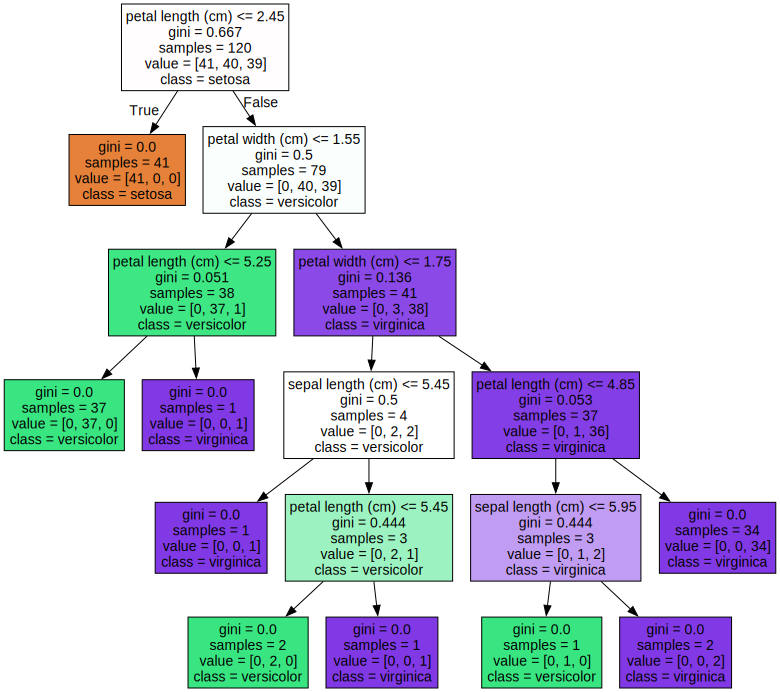

In [4]:
import graphviz

with open("tree.dot") as f :
    dot_graph = f.read()
graphviz.Source(dot_graph)

max_depth, min_samples_split, min_samples_leaf 등 하이퍼 파라미터를 조절하여 depth 설정

feature 별 중요도 추출

Feature imporances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) :  0.025
sepal width (cm) :  0.000
petal length (cm) :  0.555
petal width (cm) :  0.420


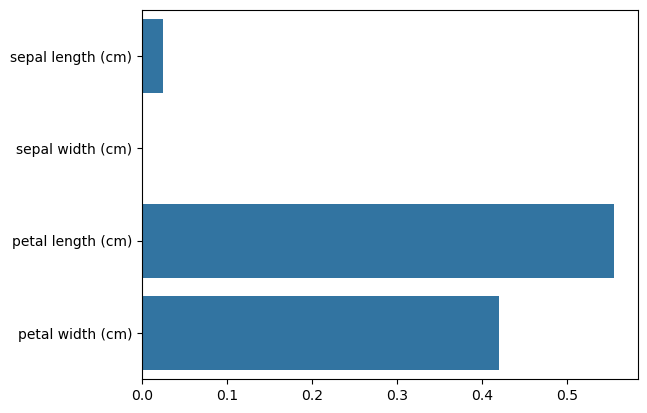

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print("Feature imporances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1: .3f}'.format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)
plt.show()

결정 트리 과적합

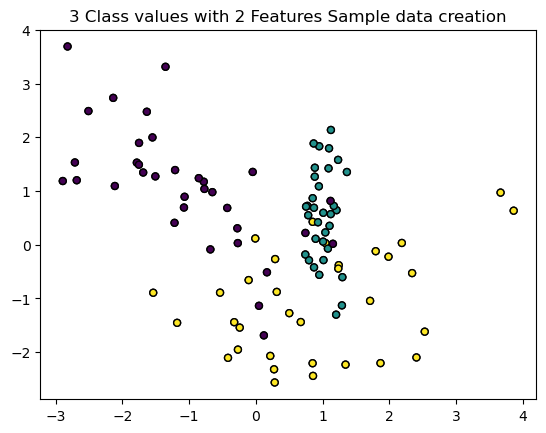

In [11]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:,1], marker='o',c=y_labels, s=25, edgecolor='k')

plt.show()

In [17]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)
    plt.show()

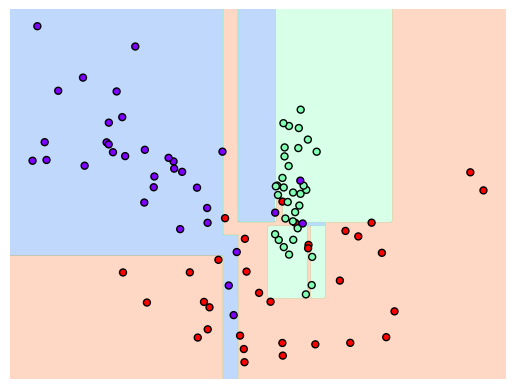

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

이상치로 인해 결정 기준 경계가 많은 것을 확인

6개 이하의 데이터는 리프 노드를 생성할 수 있도록 생성 규칙을 완화한 후 결정 기준 경계 확인

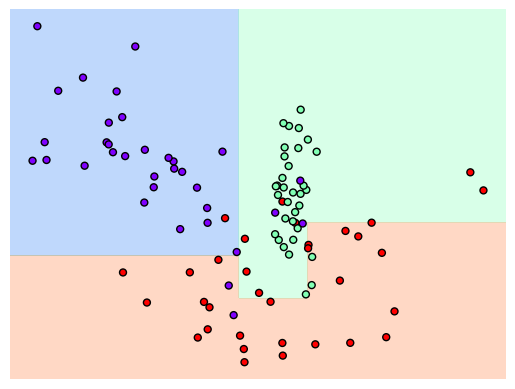

In [19]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

## 앙상블 학습

+ Voting : 서로 다른 알고리즘을 가진 분류기 결합
+ Bagging : 각각의 분류기가 모두 같은 유형의 알고리즘 기반이나, 데이터 샘플링을 다르게 함. 예) 랜덤 포레스트
+ Boosting : 여러 개의 분류기가 순차적으로 학습을 수행하되, 다음 분류기에는 가중치를 부여하여 예측이 틀린 데이터에 대해 올바르게 예측할 수 있도록 함.
+ Stacking : 여러 가지 다른 모델의 예측 결과값을 다시 학습 데이터로 만들어서 다른 모델(메타 모델)로 재학습시켜 결과를 예측.
  

### 위스콘신 유방암 데이터 예측

In [20]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [22]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


보팅으로 무조건 정확도가 높아지는 것은 아니므로.. 

어떻게 높은 유연성을 가지고 현실에 대처할 수 있는가가 ML 모델의 중요한 평가 요소가 됨.

편향-분산 트레이드 오프는 ML 모델이 극복해야 할 중요 과제.

결정 트리 알고리즘의 장점을 그대로 사용하고 단점은 보완하면서 편향-트레이드오프의 효과를 극대화할 수 있음.

## 렌덤 포레스트